In [1]:
import pandapower as pp
import pandas as pd
import numpy as np
import pyomo.environ as pyo

from master_model_S import master_model
from slave_model_S import slave_model_candidate_indexed
from slave_model.sets import slave_model_sets
from slave_model.constraints import slave_model_constraints
from slave_model.parameters import slave_model_parameters
from slave_model.variables import slave_model_variables
import polars as pl
from polars import col as c
from general_function import pl_to_dict
from polars_function import list_to_list_of_tuple

from dig_a_plan_pipeline import DigAPlan


In [2]:

# -------------------------
# Global Connectivity Dictionary for Instance Data.
# -------------------------
# F_instance provides two candidate pairs for each branch.
F_instance = {
    0: [(0, 1), (1, 0)],
    1: [(1, 2), (2, 1)],
    2: [(1, 3), (3, 1)],
    3: [(2, 4), (4, 2)],
    4: [(2, 5), (5, 2)],
    5: [(5, 6), (6, 5)],
    6: [(3, 6), (6, 3)],
    7: [(4, 7), (7, 4)],
    8: [(6, 7), (7, 6)]
}



# -------------------------
# (A) Create the pandapower network.
# -------------------------
def create_pandapower_net():
    net = pp.create_empty_network()
    for i in range(8):
        pp.create_bus(net, vn_kv=20, name=f"bus_{i}")
    pp.create_ext_grid(net, bus=0, vm_pu=1.0, name="Grid Connection")
    
    p_load_dict = {0: 0.0, 1: 0.1, 2: 0.12, 3: 0.15, 4: 0.08, 5: 0.1, 6: 0.12, 7: 0.06}
    q_load_dict = {0: 0.0, 1: 0.03, 2: 0.04, 3: 0.05, 4: 0.02, 5: 0.03, 6: 0.04, 7: 0.02}
    # Global line parameters.
    r_dict = {1: 0.02, 2: 0.02, 3: 0.03, 4: 0.03, 5: 0.01, 6: 0.02, 7: 0.02, 8: 0.04}
    x_dict = {1: 0.04, 2: 0.04, 3: 0.05, 4: 0.05, 5: 0.02, 6: 0.03, 7: 0.03, 8: 0.06}
    for bus in p_load_dict:
        p = p_load_dict[bus]
        q = q_load_dict[bus]
        if p > 0:
            pp.create_load(net, bus=bus, p_mw=p, q_mvar=q, name=f"load_{bus}")
    
    # For each branch l, use the first candidate of F_instance for network topology.
    for l in sorted(F_instance.keys()):
        from_bus, to_bus = F_instance[l][0]  # Use first candidate for creating the network.
        pp.create_line_from_parameters(
            net,
            from_bus=from_bus,
            to_bus=to_bus,
            length_km=1.0,
            r_ohm_per_km=r_dict.get(l, 0.01),
            x_ohm_per_km=x_dict.get(l, 0.05),
            c_nf_per_km=0.0,
            max_i_ka=1.0,
            name=f"line_{l}"
        )
    
    switchable_keys = [1, 2, 3, 4, 5, 6, 7, 8]
    for key in switchable_keys:
        mask = net.line["name"] == f"line_{key}"
        if mask.sum() == 0:
            raise KeyError(f"No line found with name 'line_{key}'")
        line_idx = net.line.index[mask][0]
        line = net.line.loc[line_idx]
        pp.create_switch(
            net, bus=line["from_bus"], element=line_idx, et="l",
            closed=True, type="CB", name=f"switch_{key}")
    
    pp.create_sgen(net, bus=1, p_mw=0.0, q_mvar=0.0, name="dummy_sgen")
    if net.trafo.empty:
        dummy_trafo = {
            "hv_bus": 0,
            "lv_bus": 1,
            "sn_mva": 0.001,
            "vn_hv_kv": 20,
            "vn_lv_kv": 20,
            "vk_percent": 10.0,
            "vkr_percent": 5.0,
            "i0_percent": 0.0,
            "pfe_kw": 0.0,
            "name": "dummy_trafo"
        }
        net.trafo = pd.DataFrame([dummy_trafo])
    return net


In [3]:

net = create_pandapower_net()

# -------------------------
# (B) Build and Solve the Master Model.
# -------------------------
# Build instance data for the master model.
instance_data_master = {
    None: {
        'I': {None: list(net.bus.index)},
        'L': {None: list(net.line.index)},
        # For the master, we provide F as a single candidate per branch.
        'F': { 
            i: tuple(F_instance[int(net.line.loc[i, "name"].split("_")[1])][0])
            for i in net.line.index },
        # S: set of switchable lines.
        'S': {None: [i for i in net.line.index if int(net.line.loc[i, "name"].split("_")[1]) in [1,2,3,4,5,6,7,8]]},
        'r': { i: net.line.loc[i, "r_ohm_per_km"] for i in net.line.index },
        'x': { i: net.line.loc[i, "x_ohm_per_km"] for i in net.line.index },
        'p_load': {0: 0.0, 1: 0.1, 2: 0.12, 3: 0.15, 4: 0.08, 5: 0.1, 6: 0.12, 7: 0.06},
        'q_load': {0: 0.0, 1: 0.03, 2: 0.04, 3: 0.05, 4: 0.02, 5: 0.03, 6: 0.04, 7: 0.02},
        'M': {None: 1e4},
    }
}

net = create_pandapower_net()
master_instance = master_model().create_instance(instance_data_master)
solver = pyo.SolverFactory('gurobi')
solver.options['NonConvex'] = 2

results = solver.solve(master_instance, tee=False)
# master_instance.display()




In [6]:
master_instance.d.extract_values() 

{(0, 0, 1): 1.0,
 (1, 1, 2): 1.0,
 (2, 1, 3): 1.0,
 (3, 2, 4): 1.0,
 (4, 2, 5): 1.0,
 (5, 5, 6): 0.0,
 (6, 3, 6): 1.0,
 (7, 4, 7): 0.0,
 (8, 6, 7): 1.0}

In [5]:
C_instance

{0: [(0, 1)],
 1: [(1, 2)],
 2: [(1, 3)],
 3: [(2, 4)],
 4: [(2, 5)],
 5: [(5, 6)],
 6: [(3, 6)],
 7: [(4, 7)],
 8: [(6, 7)]}

In [ ]:
C_instance =  pl_to_dict(
    pl.from_pandas(net.line.reset_index())
    .select(
        c("index"), 
        pl.concat_list("from_bus", "to_bus").pipe(list_to_list_of_tuple)
        )
    )


# Now, build the instance data dictionary for the slave model.
# Here we do not supply separate parent and child because the candidate-based model uses F.
instance_data_slave = {
    None: {
        'N': {None: list(net.bus.index)},
        'L': {None: list(net.line.index)},
        # For connectivity, we now supply F as the full candidate list for each branch.
        'C': C_instance,
        # Electrical parameters.
        'r': { i: net.line.loc[i, "r_ohm_per_km"] for i in net.line.index },
        'x': { i: net.line.loc[i, "x_ohm_per_km"] for i in net.line.index },
        'b': { i: 0.05 for i in net.line.index},
        # Loads (here using the same as in master instance)
        'p_node': {0: 0.0, 1: 0.1, 2: 0.12, 3: 0.15, 4: 0.08, 5: 0.1, 6: 0.12, 7: 0.06},
        'q_node': {0: 0.0, 1: 0.03, 2: 0.04, 3: 0.05, 4: 0.02, 5: 0.03, 6: 0.04, 7: 0.02},
        'M': {None: 1e4},
        # 'vmin': {None: 0.9},
        # 'vmax': {None: 1.1},
        # Pass the master branch activation decisions from the master model over the candidate set.
        'master_d': master_instance.d.extract_values() 
    }
}

# Now, create and solve the slave model.
solver = pyo.SolverFactory('gurobi')
solver.options['NonConvex'] = 2

grid_data: dict[str, pl.DataFrame] = {"node_data": pl.DataFrame(), "edge_data": pl.DataFrame()}

dig_a_plan: DigAPlan = DigAPlan()
dig_a_plan.add_grid_data(**grid_data)

slave_model: pyo.AbstractModel = pyo.AbstractModel() # type : ignore
slave_model = slave_model_sets(slave_model)
slave_model = slave_model_parameters(slave_model)
slave_model = slave_model_variables(slave_model)
slave_model = slave_model_constraints(slave_model)

slave_instance = slave_model.create_instance(instance_data_slave)
results_slave = solver.solve(slave_instance, tee=False)

print("Slave model solution:")
# slave_instance.display()


slave_instance.p_z_up.display()
slave_instance.p_z_dn.display()
slave_instance.i_sq.display()

slave_instance.q_z_up.display()
slave_instance.q_z_dn.display()

ValueError: line_data is not a valid name

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import pyomo.environ as pyo

def tree_layout(G, root=0):
    """Generate a tree-like layout using a breadth-first search from the root."""
    UG = G.to_undirected()
    queue = deque([root])
    visited = {root}
    level = {root: 0}
    while queue:
        u = queue.popleft()
        for v in UG[u]:
            if v not in visited:
                visited.add(v)
                level[v] = level[u] + 1
                queue.append(v)
    level_dict = {}
    for node, lv in level.items():
        level_dict.setdefault(lv, []).append(node)
    pos = {}
    for lv, nodes in level_dict.items():
        offset = -(len(nodes)-1)/2.0
        for i, node in enumerate(nodes):
            pos[node] = (lv, i + offset)
    return pos


ModuleNotFoundError: No module named 'matplotlib'

/tmp/ipykernel_430179/1144385426.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(scatterpoints=1)


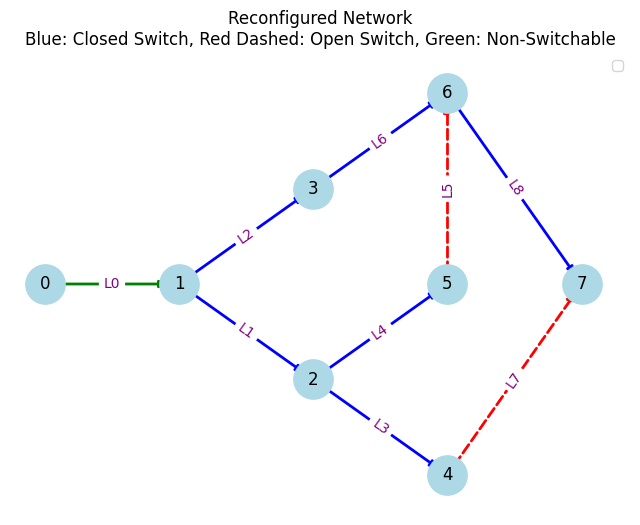

In [ ]:
def plot_solution_with_switch_status(instance):
    """
    Plots the reconfigured network using the solution from the master model.

    This version uses the candidate set model.LF (which is a set of tuples (l, i, j)).
    For each line l, the function finds the candidate (i,j) in instance.LF with l as its first element
    that is active (i.e., instance.d[l, i, j] >= 0.5) if possible. If the line is switchable and the switch
    is open (instance.z[l] < 0.5), a default candidate is chosen (here, the first candidate in instance.F[l]).
    """
    closed_switch_edges = []
    open_switch_edges = []
    non_switchable_edges = []
    edge_labels = {}

    # Loop over each line in the network
    for l in instance.L:
        effective_edge = None
        # Look for an active candidate for line l.
        for (l_candidate, i, j) in instance.LF:
            if l_candidate != l:
                continue
            d_val = pyo.value(instance.d[l_candidate, i, j])
            if d_val is not None and d_val >= 0.5:
                effective_edge = (i, j)
                break
        
        # If no candidate is active and the line is switchable (and supposed to be open),
        # use a default candidate (e.g., the first candidate from instance.F[l]).
        if effective_edge is None and l in instance.S:
            # Pick the first candidate from instance.F[l] as default
            # (Assuming instance.F[l] is a tuple or list; adjust accordingly)
            default_candidate = list(instance.F[l])[0]
            effective_edge = default_candidate

        # If still no candidate is found (for non-switchable lines, this should not happen), skip.
        if effective_edge is None:
            continue

        edge_labels[effective_edge] = f"L{l}"
        
        if l in instance.S:
            # For switchable lines, determine status using the switch variable.
            z_val = pyo.value(instance.Delta[l])
            if z_val is not None and z_val >= 0.5:
                closed_switch_edges.append(effective_edge)
            else:
                open_switch_edges.append(effective_edge)
        else:
            non_switchable_edges.append(effective_edge)

    # Create a directed graph for visualization
    G_all = nx.DiGraph()
    for node in instance.I:
        G_all.add_node(node)
    for edge in closed_switch_edges + open_switch_edges + non_switchable_edges:
        G_all.add_edge(*edge)
    
    pos = tree_layout(G_all, root=0)
    
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G_all, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(G_all, pos)
    
    # Draw edges with different styles based on the switch status.
    nx.draw_networkx_edges(G_all, pos, edgelist=closed_switch_edges,
                           edge_color='blue', arrows=True, width=2, label='Closed Switch')
    nx.draw_networkx_edges(G_all, pos, edgelist=open_switch_edges,
                           edge_color='red', style='dashed', arrows=True, width=2, label='Open Switch')
    nx.draw_networkx_edges(G_all, pos, edgelist=non_switchable_edges,
                           edge_color='green', arrows=True, width=2, label='Non-Switchable')
    
    nx.draw_networkx_edge_labels(G_all, pos, edge_labels=edge_labels, font_color='purple')
    
    plt.title("Reconfigured Network\nBlue: Closed Switch, Red Dashed: Open Switch, Green: Non-Switchable")
    plt.axis('off')
    plt.legend(scatterpoints=1)
    plt.show()


# Example usage:
# After solving the master_model instance (e.g., master_instance),
# call:
plot_solution_with_switch_status(master_instance)
